In [3]:
import sys
sys.path.append('../utils')

import numpy as np
from keras import backend as K
from keras.layers import Input, LSTM, RepeatVector, Flatten, Masking
from keras.models import Model
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from time import time
import matplotlib.pyplot as plt
import numpy as np
import discretize_sepsis_actions as discretizer
import pickle as pkl
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
import h5py

In [4]:
class PatientRecordProcessor:
    columns = ['bloc','icustayid','charttime', 'gender', 'age', 'elixhauser',
                're_admission', 'SOFA', 'SIRS', 'Weight_kg', 'GCS', 'HR',
                'SysBP', 'MeanBP', 'DiaBP', 'Shock_Index', 'RR', 'SpO2',
                'Temp_C', 'FiO2_1', 'Potassium', 'Sodium', 'Chloride',
                'Glucose', 'BUN', 'Creatinine', 'Magnesium', 'Calcium',
                'Ionised_Ca', 'CO2_mEqL', 'SGOT', 'SGPT', 'Total_bili',
                'Albumin', 'Hb', 'WBC_count', 'Platelets_count', 'PTT',
                'PT', 'INR', 'Arterial_pH', 'paO2', 'paCO2',
                'Arterial_BE', 'Arterial_lactate', 'HCO3', 'PaO2_FiO2',
                'median_dose_vaso', 'max_dose_vaso', 'input_total_tev',
                'input_4hourly_tev', 'output_total', 'output_4hourly',
                'cumulated_balance_tev', 'sedation', 'mechvent', 'rrt',
                'died_in_hosp', 'mortality_90d']

    observ_cols = ['gender', 'age','elixhauser','re_admission', 'SOFA', 'SIRS', 'Weight_kg', 'GCS', 'HR',
                'SysBP', 'MeanBP', 'DiaBP', 'RR', 'SpO2',
                'Temp_C', 'FiO2_1', 'Potassium', 'Sodium', 'Chloride',
                'Glucose', 'BUN', 'Creatinine', 'Magnesium', 'Calcium',
                'Ionised_Ca', 'CO2_mEqL', 'SGOT', 'SGPT', 'Total_bili',
                'Albumin', 'Hb', 'WBC_count', 'Platelets_count', 'PTT',
                'PT', 'INR', 'Arterial_pH', 'paO2', 'paCO2',
                'Arterial_BE', 'Arterial_lactate', 'HCO3', 'PaO2_FiO2',
                'output_total', 'output_4hourly']
    
    action_observ_cols = ['gender', 'age','elixhauser','re_admission', 'SOFA', 'SIRS', 'Weight_kg', 'GCS', 'HR',
                'SysBP', 'MeanBP', 'DiaBP', 'RR', 'SpO2',
                'Temp_C', 'FiO2_1', 'Potassium', 'Sodium', 'Chloride',
                'Glucose', 'BUN', 'Creatinine', 'Magnesium', 'Calcium',
                'Ionised_Ca', 'CO2_mEqL', 'SGOT', 'SGPT', 'Total_bili',
                'Albumin', 'Hb', 'WBC_count', 'Platelets_count', 'PTT',
                'PT', 'INR', 'Arterial_pH', 'paO2', 'paCO2',
                'Arterial_BE', 'Arterial_lactate', 'HCO3', 'PaO2_FiO2',
                'output_total', 'output_4hourly',
                'sedation','median_dose_vaso', 'max_dose_vaso', 'input_total_tev',
                'input_4hourly_tev','sedation', 'mechvent', 'rrt']
    
    n_clusters = 2000
    
    def __init__(self):
        self.patient_map = None
        self.LONGEST_STAY = 20 
        self.OBSER_LEN = 45
    
    def load_csv(self, raw_path, cluster_path):
        print ( 'loading dataset ...' )
        self.df = pd.read_csv(raw_path)
        print ( 'loading clustered states ...' )
        self.clusters = pkl.load(open(cluster_path, 'rb'), encoding='latin1')
        print ( 'discretizing actions ...' )
        self.discretize_actions()
        print ( 'initialization succeeded' )
    
    def discretize_actions(self):
        self.action_sequence, self.vaso_bins, self.iv_bins = \
        discretizer.discretize_actions(self.df.loc[:,'input_4hourly_tev'],
                                       self.df.loc[:,'median_dose_vaso'])
    def build_patient_map(self):
        self.patient_map = {}
        for i, row in self.df.iterrows():
            icuid = str(row['icustayid'])
            state_action_outcome = [self.clusters[i], self.action_sequence[i],
                                    row['input_4hourly_tev'],
                                    row['median_dose_vaso'],
                                    row['died_in_hosp']]
            if icuid not in self.patient_map:
                # state_id, action, outcome
                self.patient_map[icuid] = {
                    'age':row['age'], 'gender':row['gender'], 'sa':[state_action_outcome],
                    'obser':[row[self.observ_cols].as_matrix()]}
            else:
                self.patient_map[icuid]['sa'].append(state_action_outcome)
                self.patient_map[icuid]['obser'].append(row[self.observ_cols].as_matrix())

        return self.patient_map
    # FOR DQN
    def build_training_history(self):
        memory = []
        if not self.patient_map:
            print ( 'building patient map ...' )
            self.patient_map = self.build_patient_map()

        for _, patient in self.patient_map.items():

            if len(patient['sa']) <= 5:
                continue

            for i, patient_icu_stay in enumerate(patient['sa']):
                _, action, _, _, outcome = patient_icu_stay
                s_obser = patient['obser'][i]
                next_s_obser = patient['obser'][i + 1]

                reward = 0
                if (i + 1) == len(patient['sa']) - 1:
                    # last stay, check the outcome
                    if patient['sa'][i + 1][-1] == 0:
                        # survived
                        reward = 15
                    else:
                        reward = -15

                memory.append(np.hstack((s_obser, action, reward, next_s_obser)))

                if reward != 0:
                    break
        return np.array(memory)
    
    def get_patient_data_seq(self):
        # icuids
        icuids =  self.df['icustayid'].values
        # observation matters
        # most of the actions are the same, that's why we diltch them
        observations = self.df[self.observ_cols].values

        self.patient_map = {}
        for i, (icuid, row) in enumerate(zip(icuids, observations)):
            if icuid not in self.patient_map:
                self.patient_map[icuid] = {}
                self.patient_map[icuid]['histories'] = [row]
            else:
                self.patient_map[icuid]['histories'] += [row]
        
        return self.patient_map
    
    def get_patient_data_seq_x(self):
        patient_seq = self.get_patient_data_seq()
        X = np.zeros((len(patient_seq.keys()), self.LONGEST_STAY, self.OBSER_LEN))
        for i, icuid in enumerate(patient_seq.keys()):
            for j, hist in enumerate(patient_seq[icuid]['histories']):
                X[i, j] = hist
        return X

In [6]:
# 5% varieity
prp = PatientRecordProcessor()
raw_csv_path = '../../data/train_scaled.csv'
state_path = '../../data/states_list.pkl'
prp.load_csv(raw_csv_path, state_path)

loading dataset ...
loading clustered states ...
discretizing actions ...
initialization succeeded


In [7]:
train_x = prp.get_patient_data_seq_x()

In [8]:
prp_test = PatientRecordProcessor()
prp_test.load_csv('../../data/test_scaled.csv', state_path)

loading dataset ...
loading clustered states ...
discretizing actions ...
initialization succeeded


In [9]:
test_x = prp_test.get_patient_data_seq_x()

In [19]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [20]:
def lstm_autoencoder(hidden_size=128):
    
    # inputs = Input(shape=(prp.LONGEST_STAY, prp.OBSER_LEN))
    inputs = Input(shape=(prp.LONGEST_STAY, prp.OBSER_LEN))
    masked_input = Masking(mask_value=0.0)(inputs)
    
    encoded = LSTM(hidden_size, input_shape=(prp.LONGEST_STAY, prp.OBSER_LEN))(masked_input)

    decoded = RepeatVector(prp.LONGEST_STAY)(encoded)
    decoded = LSTM(prp.OBSER_LEN, return_sequences=True)(decoded)
    
    sequence_autoencoder = Model(inputs, decoded)
    sequence_autoencoder.compile(optimizer='adam', loss='mse', metrics=[r2])
    
    encoder = Model(inputs, encoded)
    
    return sequence_autoencoder, encoder

In [21]:
def two_layer_lstm_autoencoder():
    
    inputs = Input(shape=(prp.LONGEST_STAY, prp.OBSER_LEN))
    
    encoded = LSTM(256, input_shape=(prp.LONGEST_STAY, prp.OBSER_LEN), return_sequences=True)(inputs)
    encoded = LSTM(128, input_shape=(prp.LONGEST_STAY, 256))(encoded)

    decoded = RepeatVector(prp.LONGEST_STAY)(encoded)
    decoded = LSTM(prp.OBSER_LEN, return_sequences=True)(decoded)
    
    sequence_autoencoder = Model(inputs, decoded)
    sequence_autoencoder.compile(optimizer='adam', loss='mse', metrics=[r2])
    
    encoder = Model(inputs, encoded)
    
    return sequence_autoencoder, encoder

In [22]:
def train_autoencoder(autoencoder, x, n_epoches=100, batch_size=128):
    x_train, x_val, _, _ = train_test_split(x, x, test_size=0.1, random_state=37)
    tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
    early_Stop = EarlyStopping(monitor='loss',
                              min_delta=0,
                              patience=5,
                              verbose=0, mode='auto')
    autoencoder.fit(x_train, x_train,
                epochs=n_epoches,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_val, x_val), verbose=1, callbacks=[early_Stop, tensorboard])

In [17]:
autoencoder, encoder = lstm_autoencoder(hidden_size=128)

In [281]:
autoencoder_action, encoder_action = lstm_autoencoder(hidden_size=128)

In [275]:
autoencoder2l, encoder2l = two_layer_lstm_autoencoder()

In [18]:
train_autoencoder(autoencoder, train_x, n_epoches=500) # with action

Train on 10408 samples, validate on 1157 samples
Epoch 1/500
10408/10408 [==============================] - 11s 1ms/step - loss: 0.5317 - r2: 0.1832 - val_loss: 0.4838 - val_r2: 0.2808
Epoch 2/500
10408/10408 [==============================] - 12s 1ms/step - loss: 0.4298 - r2: 0.3398 - val_loss: 0.4293 - val_r2: 0.3621
Epoch 3/500
10408/10408 [==============================] - 11s 1ms/step - loss: 0.3966 - r2: 0.3906 - val_loss: 0.4134 - val_r2: 0.3857
Epoch 4/500
10408/10408 [==============================] - 12s 1ms/step - loss: 0.3858 - r2: 0.4075 - val_loss: 0.4065 - val_r2: 0.3960
Epoch 5/500
10408/10408 [==============================] - 14s 1ms/step - loss: 0.3801 - r2: 0.4162 - val_loss: 0.4017 - val_r2: 0.4031
Epoch 6/500
10408/10408 [==============================] - 12s 1ms/step - loss: 0.3753 - r2: 0.4236 - val_loss: 0.3969 - val_r2: 0.4103
Epoch 7/500
10408/10408 [==============================] - 13s 1ms/step - loss: 0.3695 - r2: 0.4329 - val_loss: 0.3909 - val_r2: 0.4194

In [28]:
autoencoder_no_action.evaluate(test_x, test_x)

3885/3885 [==============================] - 3s 693us/step


[0.011337238124198972, 0.85497363948453808]

In [25]:
autoencoder_no_action, encoder_no_action = lstm_autoencoder(hidden_size=128)
train_autoencoder(autoencoder_no_action, train_x, n_epoches=500) # without action

Train on 10448 samples, validate on 1161 samples
Epoch 1/500
10448/10448 [==============================] - 11s 1ms/step - loss: 0.0587 - r2: 0.2347 - val_loss: 0.0465 - val_r2: 0.3919
Epoch 2/500
10448/10448 [==============================] - 11s 1ms/step - loss: 0.0426 - r2: 0.4446 - val_loss: 0.0398 - val_r2: 0.4786
Epoch 3/500
10448/10448 [==============================] - 11s 1ms/step - loss: 0.0338 - r2: 0.5589 - val_loss: 0.0268 - val_r2: 0.6491
Epoch 4/500
10448/10448 [==============================] - 11s 1ms/step - loss: 0.0237 - r2: 0.6909 - val_loss: 0.0221 - val_r2: 0.7110
Epoch 5/500
10448/10448 [==============================] - 11s 1ms/step - loss: 0.0206 - r2: 0.7319 - val_loss: 0.0195 - val_r2: 0.7447
Epoch 6/500
10448/10448 [==============================] - 12s 1ms/step - loss: 0.0184 - r2: 0.7601 - val_loss: 0.0174 - val_r2: 0.7716
Epoch 7/500
10448/10448 [==============================] - 12s 1ms/step - loss: 0.0171 - r2: 0.7765 - val_loss: 0.0179 - val_r2: 0.7663

In [26]:
encoder_no_action.save('encoder.h5py')

In [78]:
test_repre = patinet_encoder.predict(test_x)
train_repre = patinet_encoder.predict(train_x)

In [79]:
with open('train_patient_repre.txt', 'w') as output:
    for i, icuid in enumerate(list(prp.patient_map.keys())):
        output.write(str(icuid) + '\n')
        output.write( ','.join(map(str, train_repre[i].tolist())) + '\n' )

In [80]:
with open('test_patient_repre.txt', 'w') as output:
    for i, icuid in enumerate(list(prp_test.patient_map.keys())):
        output.write(str(icuid) + '\n')
        output.write( ','.join(map(str, test_repre[i].tolist())) + '\n' )

### Restoring the model

In [1]:
from keras.models import load_model

Using TensorFlow backend.


In [2]:
patinet_encoder = load_model('encoder.h5py')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [14]:
train_repre = patinet_encoder.predict(train_x)

In [73]:
train_x.shape

(11563, 20, 45)

In [17]:
train_set = pd.read_csv('../../data/Sepsis_imp_train.csv')

In [21]:
ave_sofa = train_set.groupby('icustayid')['SOFA'].mean()

In [23]:
ave_sofa.values

array([  4.25      ,   6.3       ,   5.94117647, ...,   7.25      ,
        10.05      ,   2.46153846])

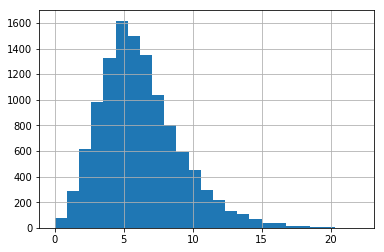

In [57]:
% matplotlib inline
pd.Series(ave_sofa.values).hist(bins=25)

In [69]:
bins = np.linspace(0, 25, 5)
groups = np.arange(0, 4)

In [70]:
sofa_labels = pd.cut(ave_sofa, bins, labels=groups)

In [65]:
with open('repre.tsv', 'w') as output:
    for i, repre in enumerate(train_repre):
        output.write( '\t'.join(map(str, repre.tolist())) + '\n' )

In [71]:
with open('repre_label.tsv', 'w') as output:
    for i, label in enumerate(sofa_labels.values):
        output.write( str(label) + '\n' )